### **Libraries**

In [1]:
#Loader
import pandas as pd
import matplotlib.pyplot as plt
from kloppy import pff

### **Data Loading**

In [2]:
# paths to data files
roster_path = "/home/student/Documents/AIMS/Intership/pysport/pysport-aims/first_week/data/3812/3812_roster.json"
metadata_path = "/home/student/Documents/AIMS/Intership/pysport/pysport-aims/first_week/data/3812/3812_metadata.json"
raw_data_path = "/home/student/Documents/AIMS/Intership/pysport/pysport-aims/first_week/data/3812/3812.jsonl.bz2"

In [3]:
# Load the dataset for match ID 3812.
dataset = pff.load_tracking(
    raw_data = raw_data_path,
    meta_data = metadata_path,
    roster_meta_data = roster_path,
    coordinates= "pff",
    limit= None,
    sample_rate= None
)

dataset.to_df().head(5)

,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,13228_x,...,8033_d,8033_s,8326_x,8326_y,8326_d,8326_s,8327_x,8327_y,8327_d,8327_s
0,1,0 days 00:00:00,4226,alive,366,2.46,1.58,0.0,None,14.357,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,1,0 days 00:00:00.033041,4227,alive,366,2.04,1.62,0.0,None,14.335,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,1,0 days 00:00:00.066408,4228,alive,366,1.62,1.67,0.0,None,14.313,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,1,0 days 00:00:00.099774,4229,alive,366,1.20,1.71,0.0,None,14.291,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,1,0 days 00:00:00.133141,4230,alive,366,0.78,1.76,0.0,None,14.270,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None


### **we rewrite here the code of the first animation using kloppy functionalities as most as we can**

In [4]:
# limit the frame to the 20s range on which we want to work on
selected_dataset = dataset.filter(lambda frame: (frame.timestamp.total_seconds() < 20) & (frame.period.id == 1))

# by this we conserve the dataset type by reduicing the number of frame to the ones we want.
print(type(selected_dataset),len(selected_dataset))

<class 'kloppy.domain.models.tracking.TrackingDataset'> 600


In [5]:
# from the limited dataset we can now extract first the dataframe of the ball coordinates first.
ball_coordinates = selected_dataset.to_df()[["frame_id","ball_x","ball_y"]]
ball_coordinates.head()

,frame_id,ball_x,ball_y
0,4226,2.46,1.58
1,4227,2.04,1.62
2,4228,1.62,1.67
3,4229,1.20,1.71
4,4230,0.78,1.76


In [6]:
# store the home and away team data
home_team, away_team = dataset.metadata.teams

In [8]:
# get the dataframe of the home team players

# first get the formated list of ids of the home players 
dims = ["x","y"]
home_player_ids = [f"{player.player_id}_{dim}" for player in home_team.players if f"{player.player_id}_x" in selected_dataset.to_df().columns for dim in dims]

# now get the sub dataframe of their positions
home_team_pos = selected_dataset.to_df()[["frame_id"]+home_player_ids]
home_team_pos.head()

,frame_id,7988_x,7988_y,9993_x,9993_y,214_x,214_y,3858_x,3858_y,3903_x,...,13901_x,13901_y,3848_x,3848_y,428_x,428_y,2059_x,2059_y,474_x,474_y
0,4226,-0.771,-9.960,19.462,3.407,9.501,-1.919,7.011,-8.378,2.879,...,7.543,4.958,18.819,-21.928,1.351,-22.141,42.184,-0.469,18.662,-4.934
1,4227,-0.833,-9.884,19.431,3.434,9.478,-1.890,6.947,-8.298,2.851,...,7.527,4.993,18.782,-21.922,1.333,-22.092,42.173,-0.464,18.639,-4.912
2,4228,-0.895,-9.810,19.401,3.460,9.455,-1.862,6.883,-8.218,2.823,...,7.512,5.028,18.746,-21.915,1.315,-22.045,42.163,-0.459,18.615,-4.890
3,4229,-0.957,-9.735,19.370,3.486,9.432,-1.834,6.820,-8.140,2.796,...,7.497,5.063,18.710,-21.909,1.298,-21.998,42.152,-0.454,18.591,-4.867
4,4230,-1.019,-9.661,19.339,3.511,9.409,-1.807,6.757,-8.062,2.768,...,7.481,5.097,18.674,-21.903,1.280,-21.952,42.142,-0.449,18.567,-4.845


In [10]:
# rotate to get the player_ids as a column the x position and the y position as a columns too
# Melt the dataframe
melted = home_team_pos.copy().reset_index().melt(id_vars='frame_id', var_name='player_coord', value_name='position')
# Split player_id and coordinate
melted[['player_id', 'coord']] = melted['player_coord'].str.extract(r'(\d+)_([xy])')
# Pivot so x and y are separate columns
home_rotated = melted.pivot_table(index=['frame_id', 'player_id'], columns='coord', values='position').reset_index()
# rename columns
home_rotated = home_rotated.rename(columns={'x': 'x_pos', 'y': 'y_pos'})
home_rotated.head()

coord,frame_id,player_id,x_pos,y_pos
0,4226,13228,14.357,18.306
1,4226,13901,7.543,4.958
2,4226,2059,42.184,-0.469
3,4226,214,9.501,-1.919
4,4226,3848,18.819,-21.928


In [9]:
# replication for the away tea player's
away_players_ids = [f"{player.player_id}_{dim_}" for player in away_team.players if f"{player.player_id}_x"in selected_dataset.to_df().columns for dim_ in dims]
away_team_pos = selected_dataset.to_df()[["frame_id"]+away_players_ids]

# rotation 
away_melted = away_team_pos.copy().reset_index().melt(id_vars='frame_id', var_name='player_coord', value_name='position')
away_melted[['player_id', 'coord']] = away_melted['player_coord'].str.extract(r'(\d+)_([xy])')
away_rotated = away_melted.pivot_table(index=['frame_id', 'player_id'], columns='coord', values='position').reset_index()
away_rotated = away_rotated.rename(columns={'x': 'x_pos', 'y': 'y_pos'})
away_rotated.head()

coord,frame_id,player_id,x_pos,y_pos
0,4226,11094,1.247,-11.488
1,4226,11241,-30.699,-9.363
2,4226,1522,-11.375,1.698
3,4226,284,-21.746,14.948
4,4226,3315,2.461,1.580


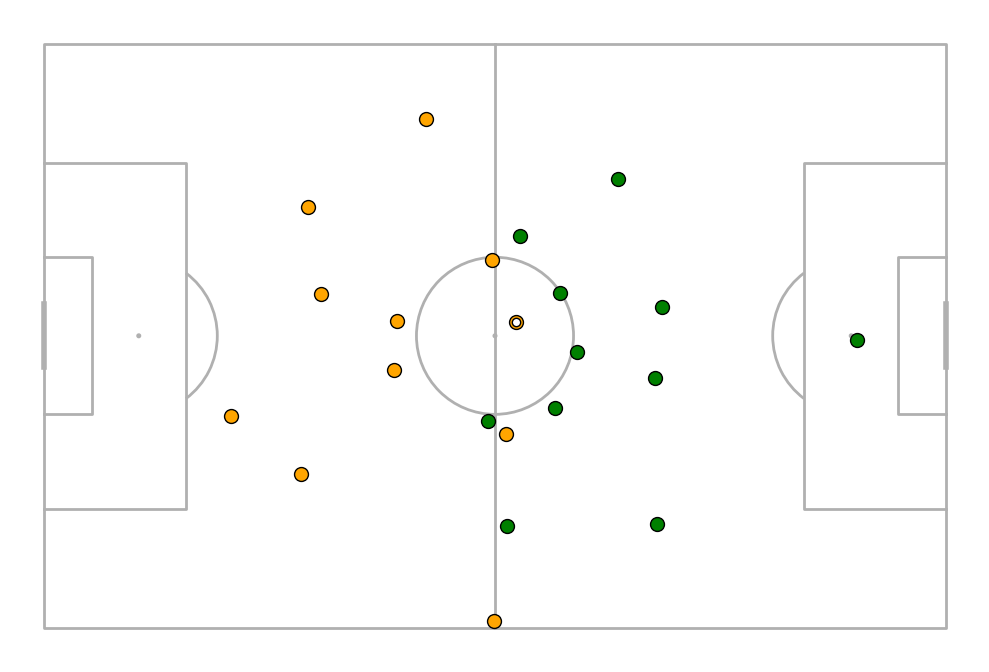

In [13]:
# then now I can plot the animation.
from mplsoccer import Pitch
from matplotlib import animation


pitch = Pitch(pitch_type='skillcorner', goal_type='line', pitch_width=68, pitch_length=105)
fig, ax = pitch.draw(figsize=(10, 7.4))

# then setup the pitch plot markers we want to animate
marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
ball, = ax.plot([], [], ms=6, markerfacecolor='w', zorder=3, **marker_kwargs)
away, = ax.plot([], [], ms=10, markerfacecolor='orange', **marker_kwargs)  
home, = ax.plot([], [], ms=10, markerfacecolor='green', **marker_kwargs) 

# animation function
def animate(i):
    """ Function to animate the data. Each frame it sets the data for the players and the ball."""
    # set the ball data with the x and y positions for the ith frame
    ball.set_data(ball_coordinates.iloc[i, [1]], ball_coordinates.iloc[i, [2]])
    # get the frame id for the ith frame
    frame = ball_coordinates.iloc[i, 0]
    # set the player data using the frame id
    away.set_data(away_rotated.loc[away_rotated.frame_id == frame, 'x_pos'],
                  away_rotated.loc[away_rotated.frame_id == frame, 'y_pos'])
    home.set_data(home_rotated.loc[home_rotated.frame_id == frame, 'x_pos'],
                  home_rotated.loc[home_rotated.frame_id == frame, 'y_pos'])
    return ball, away, home


# call the animator, animate so 25 frames per second
anim = animation.FuncAnimation(fig, animate, frames=len(ball_coordinates), interval=33, blit=True)

plt.show()


In [14]:
anim.save("animation2.mp4", fps=30, extra_args=['-vcodec', 'libx264'])